In [1]:
%matplotlib notebook
%matplotlib inline
%autosave 120

Autosaving every 120 seconds


In [2]:
import os
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandarallel import pandarallel
import multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from microsim.bp_treatment_strategies import *

from microsim.outcome_model_repository import OutcomeModelRepository
from microsim.outcome_model_type import OutcomeModelType
from microsim.person import Person

from microsim.population import NHANESDirectSamplePopulation

from microsim.bp_treatment_strategies import SprintTreatment

from microsim.sim_settings import simSettings

from microsim.trials.trialset import TrialsetParallel, TrialsetSerial
from microsim.trials.trial_description import TrialDescription
from microsim.trials.logistic_regression_analysis import LogisticRegressionAnalysis
from microsim.trials.linear_regression_analysis import LinearRegressionAnalysis
from microsim.trials.outcome_assessor import OutcomeAssessor
from microsim.trials.attribute_outcome_assessor import AttributeOutcomeAssessor
from microsim.trials.attribute_outcome_assessor import AssessmentMethod
from microsim.trials.risk_filter import RiskFilter
from microsim.trials.trial_utils import get_analysis_name, randomizationSchema

In [4]:
#any microsim dir will work, just need to access the NHANES data
#microsimDir = "/users/PAS2164/deligkaris/MICROSIM/CODE/microsim"
microsimDir = "/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/CODE/microsim"
os.chdir(microsimDir)

In [5]:
#at the beginning turn on pandarallel if you are planning to use TrialsetSerial
pandarallel.initialize(verbose=1) #microsim by default now does not initialize pandarallel
simSettings.pandarallelFlag = True #with this flag all new population instances will be set to use pandarallel

In [6]:
%%time
#with pandarallel on these two steps are faster
#12min with 10,000, 22min with 20,000, 61min with 60,000, 102min with 100,000
#osc: 27min with 10,000
pop = NHANESDirectSamplePopulation(100000, 1999)
alive, df = pop.advance_vectorized(200)

/Users/deligkaris.1/Library/Caches/pypoetry/virtualenvs/microsim-54NoInYP-py3.9/lib/python3.9/site-packages/pandarallel/data_types/series.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]
/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/gfr_equation.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return constant * (x.creatinine / crThreshold) ** exponent * 0.993**x.age
/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/gfr_equation.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return constant * (x.creatinine / crThreshold)

CPU times: user 1h 17min 14s, sys: 6min 57s, total: 1h 24min 12s
Wall time: 1h 42min 25s


In [7]:
def getDFForPersonCol(person):
    df = pd.DataFrame(person.get_final_wave_state_as_dict())
    df['cvRisk'] = df.apply(OutcomeModelRepository().get_risk_for_person, args=(OutcomeModelType.CARDIOVASCULAR, 1, True), axis='columns')
    df['demRisk'] = df.apply(OutcomeModelRepository().get_risk_for_person,  args=(OutcomeModelType.DEMENTIA, 1, True), axis='columns')
    return df

dfs = pop._people.apply(getDFForPersonCol)

In [8]:
#pop._people.iloc[1].get_final_wave_state_as_dict()

In [79]:
allAgesDF = pd.concat(dfs.tolist())

In [80]:
allAgesDF.head()

,sbp,dbp,a1c,hdl,ldl,trig,totChol,bmi,anyPhysicalActivity,afib,alcoholPerWeek,creatinine,antiHypertensiveCount,statin,waist,alive,gcp,bpMedsAdded,age,baseAge,gender,raceEthnicity,black,current_diabetes,gfr,education,current_bp_treatment,smokingStatus,current_smoker,gcpRandomEffect,miPriorToSim,strokePriorToSim,mi,stroke,ageAtFirstStroke,ageAtFirstMI,ageAtFirstDementia,miInSim,strokeInSim,dementia,baseGcp,gcpSlope,totalYearsInSim,totalBPMedsAdded,totalQalys,cvRisk,demRisk
0,152.501088,75.147321,5.143295,52.631502,92.288743,142.448264,164.205937,25.473409,True,False,1,0.703879,1,True,97.894037,True,43.797810,0.0,70.0,69.0,1,3,False,False,95.397816,4,True,1,False,-5.272078,1,0,1,False,NaN,59.0,NaN,False,False,False,57.558408,0.000000,1,0.0,0,0.010316,0.000221
1,152.182562,75.840479,5.164453,52.888468,92.592632,135.725612,164.976429,25.496095,True,False,1,0.704050,1,True,97.902995,True,48.247244,0.0,71.0,69.0,1,3,False,False,94.720571,4,True,1,False,-5.272078,1,0,1,False,NaN,59.0,NaN,False,False,False,57.558408,-13.760597,2,0.0,0,0.010937,0.000546
2,151.894643,75.977417,5.182780,53.082751,92.476760,132.077807,165.192420,25.525505,True,False,1,0.703662,2,False,98.016533,True,43.306194,0.0,72.0,69.0,1,3,False,False,94.078872,4,True,1,False,-5.272078,1,0,1,False,NaN,59.0,NaN,False,False,False,57.558408,4.449434,3,0.0,0,0.011579,0.000917
3,150.438760,74.975908,5.195389,53.044179,95.171952,137.623767,169.526639,25.514385,True,False,1,0.706461,1,False,98.002905,True,44.032614,0.0,73.0,69.0,1,3,False,False,93.268024,4,True,1,False,-5.272078,1,0,1,False,NaN,59.0,NaN,False,False,False,57.558408,-4.941050,4,0.0,0,0.012341,0.001386
4,151.067094,75.824135,5.180465,53.059764,95.967727,137.911951,170.813577,25.448550,True,False,1,0.698017,2,True,97.739971,True,42.372110,0.0,74.0,69.0,1,3,False,False,93.073990,4,True,1,False,-5.272078,1,0,1,False,NaN,59.0,NaN,False,False,False,57.558408,0.726420,5,0.0,0,0.013205,0.001925


In [81]:
#allAgesDF.loc[allAgesDF.demRisk > 1, 'demRisk'].count(), allAgesDF.loc[allAgesDF.demRisk > 1, 'demRisk']

In [82]:
allAgesDF.loc[allAgesDF.demRisk > 1, 'demRisk'] = 1

In [83]:
allAgesDF.demRisk.describe(), allAgesDF.cvRisk.describe()

(count    4.029125e+06
 mean     2.528187e-02
 std      7.154125e-02
 min      3.352533e-08
 25%      3.278151e-04
 50%      2.830989e-03
 75%      1.754265e-02
 max      1.000000e+00
 Name: demRisk, dtype: float64,
 count    4.029125e+06
 mean     7.715405e-03
 std      9.411568e-03
 min      1.166614e-06
 25%      1.160593e-03
 50%      4.085256e-03
 75%      1.086829e-02
 max      9.311968e-02
 Name: cvRisk, dtype: float64)

In [84]:
#if some points are outside of the min and max of this then qcut will return them to belong in NaN
#np.arange(increment, 1.0, increment)

In [85]:
#we need to have n+1 points in order to have n intervals
#len(np.arange(increment, 1.0, increment)),len(np.arange(0, 1.0, increment)),len(np.arange(0, 1.0+increment, increment))

In [86]:
nQuantiles = 25
increment = 1.0/nQuantiles
#qcut will move the left boundary to a value lower than the min, so that the left end (which is open)
#will include the min
allAgesDF['demRiskQuantile'] = pd.qcut(allAgesDF.demRisk, np.arange(0, 1.0+increment, increment))
allAgesDF['cvRiskQuantile'] = pd.qcut(allAgesDF.cvRisk, np.arange(0, 1.0+increment, increment))

In [87]:
#allAgesDF.shape

In [88]:
#there should not be any NaNs
allAgesDF['demRiskQuantile'].isna().sum(), allAgesDF['cvRiskQuantile'].isna().sum()

(0, 0)

In [89]:
#allAgesDF['demRiskQuantile'].head()

In [90]:
meanDemRiskForQuantile = allAgesDF.groupby('demRiskQuantile')['demRisk'].mean()
meanCVRiskForQuantile = allAgesDF.groupby('cvRiskQuantile')['demRisk'].mean()
meanDemRiskForQuantileDict = {index : value for index, value in meanDemRiskForQuantile.items()}
meanCVRiskForQuantileDict = {index : value for index, value in meanCVRiskForQuantile.items()}
demQuantileNumberForQuantile = {quantile : index for index, quantile in enumerate(allAgesDF['demRiskQuantile'].value_counts().index)}
cvQuantileNumberForQuantile = {quantile : index for index, quantile in enumerate(allAgesDF['cvRiskQuantile'].value_counts().index)}
demQuantileForNumber = {index : quantile for index, quantile in enumerate(allAgesDF['demRiskQuantile'].value_counts().index)}
cvQuantileForNumber = {index : quantile for index, quantile in enumerate(allAgesDF['cvRiskQuantile'].value_counts().index)}

In [91]:
#allAgesDF['demRiskQuantile'].value_counts().index

In [92]:
#meanDemRiskForQuantile, meanDemRiskForQuantileDict, demQuintileNumberForQuantile

In [93]:
allAgesDF['meanDemRiskForQuantile'] = allAgesDF['demRiskQuantile']
allAgesDF['meanDemRiskForQuantile'].replace(meanDemRiskForQuantileDict, inplace=True)
allAgesDF['meanCVRiskForQuantile'] = allAgesDF['cvRiskQuantile']
allAgesDF['meanCVRiskForQuantile'].replace(meanCVRiskForQuantileDict, inplace=True)

allAgesDF['cvQuantileNum'] = allAgesDF['cvRiskQuantile']
allAgesDF['cvQuantileNum'].replace(cvQuantileNumberForQuantile, inplace=True)

allAgesDF['demQuantileNum'] = allAgesDF['demRiskQuantile']
allAgesDF['demQuantileNum'].replace(demQuantileNumberForQuantile, inplace=True)

In [94]:
allAgesDF.head()

,sbp,dbp,a1c,hdl,ldl,trig,totChol,bmi,anyPhysicalActivity,afib,alcoholPerWeek,creatinine,antiHypertensiveCount,statin,waist,alive,gcp,bpMedsAdded,age,baseAge,gender,raceEthnicity,black,current_diabetes,gfr,education,current_bp_treatment,smokingStatus,current_smoker,gcpRandomEffect,miPriorToSim,strokePriorToSim,mi,stroke,ageAtFirstStroke,ageAtFirstMI,ageAtFirstDementia,miInSim,strokeInSim,dementia,baseGcp,gcpSlope,totalYearsInSim,totalBPMedsAdded,totalQalys,cvRisk,demRisk,demRiskQuantile,cvRiskQuantile,meanDemRiskForQuantile,meanCVRiskForQuantile,cvQuantileNum,demQuantileNum
0,152.501088,75.147321,5.143295,52.631502,92.288743,142.448264,164.205937,25.473409,True,False,1,0.703879,1,True,97.894037,True,43.797810,0.0,70.0,69.0,1,3,False,False,95.397816,4,True,1,False,-5.272078,1,0,1,False,NaN,59.0,NaN,False,False,False,57.558408,0.000000,1,0.0,0,0.010316,0.000221,"(0.000186, 0.000295]","(0.00969, 0.0113]",0.000238,0.034790,12,20
1,152.182562,75.840479,5.164453,52.888468,92.592632,135.725612,164.976429,25.496095,True,False,1,0.704050,1,True,97.902995,True,48.247244,0.0,71.0,69.0,1,3,False,False,94.720571,4,True,1,False,-5.272078,1,0,1,False,NaN,59.0,NaN,False,False,False,57.558408,-13.760597,2,0.0,0,0.010937,0.000546,"(0.000445, 0.00065]","(0.00969, 0.0113]",0.000543,0.034790,12,18
2,151.894643,75.977417,5.182780,53.082751,92.476760,132.077807,165.192420,25.525505,True,False,1,0.703662,2,False,98.016533,True,43.306194,0.0,72.0,69.0,1,3,False,False,94.078872,4,True,1,False,-5.272078,1,0,1,False,NaN,59.0,NaN,False,False,False,57.558408,4.449434,3,0.0,0,0.011579,0.000917,"(0.00065, 0.000927]","(0.0113, 0.0132]",0.000782,0.042731,11,17
3,150.438760,74.975908,5.195389,53.044179,95.171952,137.623767,169.526639,25.514385,True,False,1,0.706461,1,False,98.002905,True,44.032614,0.0,73.0,69.0,1,3,False,False,93.268024,4,True,1,False,-5.272078,1,0,1,False,NaN,59.0,NaN,False,False,False,57.558408,-4.941050,4,0.0,0,0.012341,0.001386,"(0.0013, 0.00179]","(0.0113, 0.0132]",0.001530,0.042731,11,15
4,151.067094,75.824135,5.180465,53.059764,95.967727,137.911951,170.813577,25.448550,True,False,1,0.698017,2,True,97.739971,True,42.372110,0.0,74.0,69.0,1,3,False,False,93.073990,4,True,1,False,-5.272078,1,0,1,False,NaN,59.0,NaN,False,False,False,57.558408,0.726420,5,0.0,0,0.013205,0.001925,"(0.00179, 0.00243]","(0.0113, 0.0132]",0.002095,0.042731,11,14


In [95]:
### next step is to see how this varies by age...
### if we have wide distribution, then we can just go through deciles or something like that for trial sampling!

In [96]:
#allAgesDF.groupby(['cvQuantileNum', 'demQuantileNum'])['age'].count()

In [97]:
countByRisks = allAgesDF.groupby(['cvQuantileNum', 'demQuantileNum'],sort=True
                                )['age'].count().unstack(fill_value=0).stack()
#countByRisks

In [98]:
countByRisks = allAgesDF.groupby(['cvQuantileNum', 'demQuantileNum'],sort=False
                                )['age'].count().unstack(fill_value=0).stack()
#countByRisks

In [99]:
countByRisksDF = pd.DataFrame({'demRisk' : countByRisks.index.get_level_values(0),
                              'cvRisk' : countByRisks.index.get_level_values(1),
                              'ageCount' : countByRisks.values})
countByRisksDF

,demRisk,cvRisk,ageCount
0,5,0,77122
1,5,13,51614
2,5,23,21540
3,5,22,7575
4,5,21,2418
5,5,20,664
6,5,19,157
7,5,18,62
8,5,17,8
9,5,16,5


In [100]:
#used in plots later
X=np.arange(0,nQuantiles,1)
Y=np.arange(0,nQuantiles,1)
X, Y = np.meshgrid(X, Y)
X.shape

(25, 25)

In [101]:
#this is done just in case the quantile categories are not ordered properly
countByRisksArray=np.zeros(X.shape)
for i,j,k in zip(countByRisksDF["demRisk"].values,countByRisksDF["cvRisk"].values,countByRisksDF["ageCount"].values):
    countByRisksArray[i,j]=k
#countByRisksArray

In [102]:
ageCountSum = countByRisksDF["ageCount"].sum() #sum of all person-ages
ageCountSumPerQbox = ageCountSum/(nQuantiles)/(nQuantiles) # of person-ages in one qq category, uniform ditribution
ageCountSum, ageCountSumPerQbox

(4029125, 6446.6)

In [103]:
percentCutoff = 1. #relevant to a uniform distribution, which qq categories to keep
cutoff = (ageCountSumPerQbox * percentCutoff)
cutoff

6446.6

In [104]:
qqcategoriesToInclude = countByRisksDF.loc[countByRisksDF["ageCount"] > cutoff] 
#qqcategoriesToInclude, 
qqcategoriesToInclude["ageCount"].sum()/ageCountSum #percent of person-ages included

0.8618920981602706

In [105]:
#if demRisk and cvRisk are not ordered correctly, this does not work...
#countByRisksDF['ageCount'].to_numpy().reshape(nQuantiles-0, nQuantiles-0) >5000 

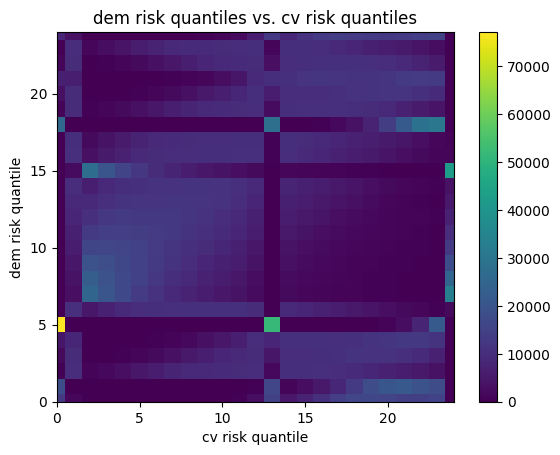

In [106]:
fig, ax = plt.subplots()

c = ax.pcolormesh(X, Y, countByRisksArray, shading='nearest')
ax.set_title('dem risk quantiles vs. cv risk quantiles')
plt.xlabel("cv risk quantile")
plt.ylabel("dem risk quantile")
# set the limits of the plot to the limits of the data
ax.axis([0,nQuantiles-1, 0,nQuantiles-1])
fig.colorbar(c, ax=ax)

plt.show()

In [107]:
# decide on which quantiles to keep
included = np.zeros(X.shape)

for i, j in zip(qqcategoriesToInclude["demRisk"],qqcategoriesToInclude["cvRisk"]):
    included[i,j]=1
    
#included

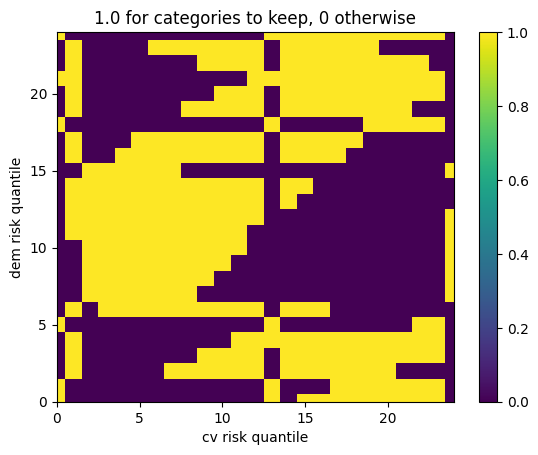

In [108]:
fig, ax = plt.subplots()

c = ax.pcolormesh(X, Y, included, shading='nearest')
ax.set_title('1.0 for categories to keep, 0 otherwise')
plt.xlabel("cv risk quantile")
plt.ylabel("dem risk quantile")
# set the limits of the plot to the limits of the data
ax.axis([0,nQuantiles-1, 0,nQuantiles-1])
fig.colorbar(c, ax=ax)

plt.show()

In [39]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [40]:
ax = Axes3D(fig)

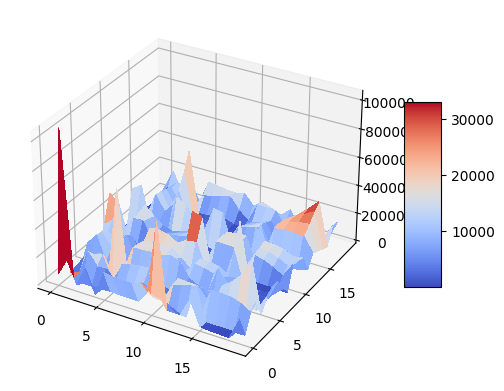

In [41]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, countByRisksArray, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [42]:
from matplotlib.colors import LightSource

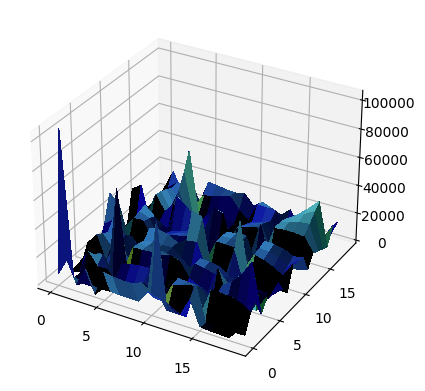

In [43]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

ls = LightSource(270, 45)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
rgb = ls.shade(countByRisksArray, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(X,Y,countByRisksArray, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)

plt.show()

In [44]:
demQuantiles = allAgesDF.demRisk.quantile(np.arange(0, 1+increment, increment).tolist())
cvQuantiles = allAgesDF.cvRisk.quantile(np.arange(0, 1+increment, increment).tolist())
quantileDF = pd.DataFrame(index=demQuantiles.index, data={'dementia' : demQuantiles.values, 'cv' : cvQuantiles.values})
quantileDF.to_csv("~/Desktop/dementiaAndCVQuintileThresholds.csv")
quantileDF

,dementia,cv
0.00,3.352533e-08,0.000001
0.05,1.278019e-05,0.000128
0.10,4.051290e-05,0.000303
0.15,9.547481e-05,0.000533
0.20,1.864303e-04,0.000818
0.25,3.278151e-04,0.001161
0.30,5.398117e-04,0.001569
0.35,8.497480e-04,0.002054
0.40,1.297032e-03,0.002625
0.45,1.932089e-03,0.003298


In [45]:
allAgesDF.demRisk.describe(), allAgesDF.cvRisk.describe()

(count    4.029125e+06
 mean     2.528187e-02
 std      7.154125e-02
 min      3.352533e-08
 25%      3.278151e-04
 50%      2.830989e-03
 75%      1.754265e-02
 max      1.000000e+00
 Name: demRisk, dtype: float64,
 count    4.029125e+06
 mean     7.715405e-03
 std      9.411568e-03
 min      1.166614e-06
 25%      1.160593e-03
 50%      4.085256e-03
 75%      1.086829e-02
 max      9.311968e-02
 Name: cvRisk, dtype: float64)

In [46]:
qqcategoriesToInclude["demRiskInterval"] = qqcategoriesToInclude["demRisk"].apply(lambda x:demQuantileForNumber[x])
qqcategoriesToInclude["cvRiskInterval"] = qqcategoriesToInclude["cvRisk"].apply(lambda x:cvQuantileForNumber[x])
#countByRisks
#allAgesDF.sample(50)

/var/folders/gw/n7s8sshd3j15_qhx38pz00x40000gq/T/ipykernel_5103/3766872978.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqcategoriesToInclude["demRiskInterval"] = qqcategoriesToInclude["demRisk"].apply(lambda x:demQuantileForNumber[x])
/var/folders/gw/n7s8sshd3j15_qhx38pz00x40000gq/T/ipykernel_5103/3766872978.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqcategoriesToInclude["cvRiskInterval"] = qqcategoriesToInclude["cvRisk"].apply(lambda x:cvQuantileForNumber[x])


In [47]:
qqcategoriesToInclude

,demRisk,cvRisk,ageCount,demRiskInterval,cvRiskInterval
0,1,0,104529,"(0.000186, 0.000328]","(0.00116, 0.00157]"
1,1,10,60323,"(0.000186, 0.000328]","(0.00501, 0.0061]"
2,1,14,24526,"(0.000186, 0.000328]","(0.0109, 0.0132]"
20,9,0,32987,"(9.55e-05, 0.000186]","(0.00116, 0.00157]"
21,9,10,35725,"(9.55e-05, 0.000186]","(0.00501, 0.0061]"
22,9,14,40422,"(9.55e-05, 0.000186]","(0.0109, 0.0132]"
23,9,9,37491,"(9.55e-05, 0.000186]","(0.000128, 0.000303]"
24,9,1,27033,"(9.55e-05, 0.000186]","(-0.00099883, 0.000128]"
25,9,5,15717,"(9.55e-05, 0.000186]","(0.000818, 0.00116]"
40,13,0,22743,"(0.00844, 0.0121]","(0.00116, 0.00157]"


In [48]:
qqcategoriesToInclude.to_csv("~/Desktop/qqcategoriesToInclude.csv")